In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

def change_date(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    return data[column]

def count_bar_plot_p( column, axis, top=None, ascending=False):
    aux0 = df_contrato[[column, 'contrato_id']].groupby(column).count().sort_values('contrato_id', ascending=False).reset_index()

    aux = inadimplentes[[column, 'contrato_id']].groupby(column).count().sort_values('contrato_id', ascending=False).reset_index()

    # sns.barplot(data=aux,x='contrato_id',y=column);
    aux = pd.merge(aux0, aux, on=column, how='inner').rename(columns={'contrato_id_x': 'total', 'contrato_id_y':'not_settled' })
    aux['%inadimplente'] = 100*aux['not_settled']/aux['total']

    aux = aux.sort_values('%inadimplente', ascending=ascending).reset_index()

    if top:
        aux= aux.head(top)
    if axis == 'horizontal':
        return sns.barplot(data=aux, x='%inadimplente', y=column)
    else: 
        return sns.barplot(data=aux, x=column, y='%inadimplente')
    

In [3]:
# original = pd.read_csv('.\#DC2022\Dados_etc\Arquivos .csv/portfolio_geral.csv', encoding='UTF-8')

In [4]:
# original['dt_ref_portfolio'] = change_date(original, 'dt_ref_portfolio')

In [7]:
# original.sort_values(['contrato_id', 'dt_ref_portfolio']).head()

In [8]:
# original.columns

### Load Data 

In [4]:
df_cliente = pd.read_csv('../portfolio_clientes.csv', encoding='UTF-8')

df_lido = pd.read_csv('df_lido.csv')


df_contrato = pd.read_csv('..df_contrato.csv', encoding='UTF-8')

df_geral_filtered = pd.read_csv('portfolio_geral_filtered.csv', encoding='UTF-8')

FileNotFoundError: [Errno 2] No such file or directory: '.\\#DC2022\\Dados_etc\\Arquivos .csv/portfolio_clientes.csv'

In [10]:
df_geral.columns

NameError: name 'df_geral' is not defined

### Limpeza e Mudança de formato

In [ ]:
#drop duplicates
df_contrato = df_contrato.drop_duplicates('contrato_id')

### Geral

In [ ]:
df_geral_filtered.head()

### Contrato

In [13]:
#dates contrato
df_contrato['dt_contrato'] = change_date(df_contrato, 'dt_contrato')
df_contrato['dt_desembolso'] = change_date(df_contrato, 'dt_desembolso')
df_contrato['dt_vencimento'] = change_date(df_contrato, 'dt_vencimento')
df_contrato['dt_wo'] = change_date(df_contrato, 'dt_wo')

#date geral
df_geral_filtered['dt_ref_portfolio'] = change_date(df_geral_filtered, 'dt_ref_portfolio')


In [15]:
df_,emsa


### Merge geral e comunicado

- Pega a linha que tem uma ação lida → proxima linha → analisa se pagou
- se sim → funcionou ,  se não → não funcionou



In [14]:
df_comunicacao = pd.read_csv('.\#DC2022\Dados_etc\Arquivos .csv/portfolio_comunicados.csv', encoding='UTF-8')
df_comunicacao['dt_ref_portfolio'] = change_date(df_comunicacao, 'dt_ref_portfolio')


df_geral_filtered = pd.merge(df_geral_filtered, df_comunicacao, on=['contrato_id', 'dt_ref_portfolio'], how='left')

### Criando df lido

In [511]:
# #pegar linha da ação
df_sorted = df_geral_filtered.sort_values(['contrato_id', 'dt_ref_portfolio']).reset_index(drop=True)

index_lido = df_sorted.loc[df_sorted['status'].isin(['LIDO', 'RESPONDIDO']), :].index

#create index list
index_lido_expanded = index_lido

index_aux = index_lido + 1
index_lido_expanded = index_lido_expanded.append(index_aux)
index_aux+=1
index_lido_expanded = index_lido_expanded.append(index_aux)
index_aux+=1
index_lido_expanded = index_lido_expanded.append(index_aux)
index_aux+=1
index_lido_expanded = index_lido_expanded.append(index_aux)
index_aux+=1
index_lido_expanded = index_lido_expanded.append(index_aux)

#get df lido
df_lido = df_sorted.iloc[index_lido_expanded, :].sort_values(['contrato_id', 'dt_ref_portfolio']).drop_duplicates().reset_index(drop=True)

index_lido = df_lido.loc[df_lido['status'].isin(['LIDO', 'RESPONDIDO']), :].index


#criando feature eficiencia
for index, i in enumerate(index_lido):
#     print(f'{index}/{len(index_lido)}')
    
    if df_lido.loc[i,'status']:

        if df_lido.loc[i,'dsp']==0: 
            pass

        else:
            for i2 in range(i+1, i+6):
                if df_lido.loc[i2, 'dsp']==0:
#                     eficiencia+=1
                    df_lido.loc[i,'eficiencia']=1
    
                    if df_lido.loc[i2, 'dspp']==0:
                        df_lido.loc[i,'eficiencia']=2
                        
                else: 
                    pass
        


df_lido['eficiencia'] = df_lido['eficiencia'].fillna(0)

SyntaxError: invalid syntax (<ipython-input-511-06d654f7537c>, line 9)

### Análise do impacto das ações LIDAS no dsp e dspp

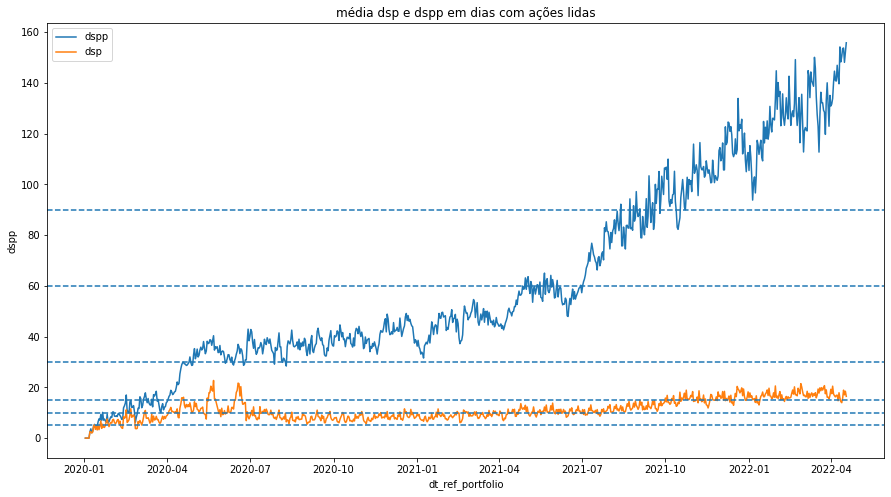

In [580]:
dsp_lido = df_lido[['dsp','dt_ref_portfolio']].groupby('dt_ref_portfolio').mean().reset_index()
dspp_lido = df_lido[['dspp','dt_ref_portfolio']].groupby('dt_ref_portfolio').mean().reset_index()
plt.figure(figsize=(15,8))

graph = sns.lineplot(data= dspp_lido,x='dt_ref_portfolio', y='dspp' )
graph = sns.lineplot(data= dsp_lido,x='dt_ref_portfolio', y='dsp' )
graph.axhline(5, ls='--')
graph.axhline(10, ls='--')
graph.axhline(15, ls='--')
graph.axhline(30, ls='--')
graph.axhline(60, ls='--')
graph.axhline(90, ls='--')
graph.set_title('média dsp e dspp em dias com ações lidas')
graph.legend(['dspp', 'dsp']);

A média de dsp não passa dos 20 dias, parece que as ações de 5, 10 e 15 funcionam. A tendência é praticamente constante até subir em 2021-08. 

Em meados de 2020 houve um média elevada de dsp, talvez provocado pela pandemia.

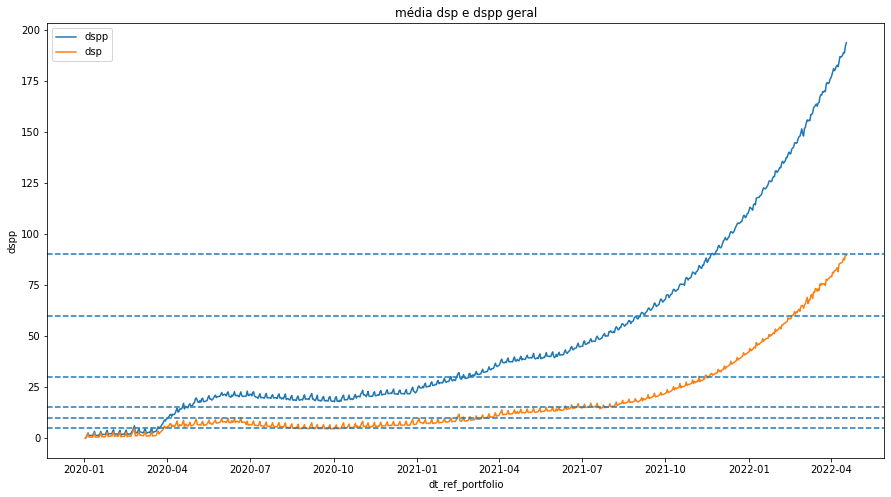

In [581]:
dsp_geral = df_sorted[['dsp','dt_ref_portfolio']].groupby('dt_ref_portfolio').mean().reset_index()
dspp_geral = df_sorted[['dspp','dt_ref_portfolio']].groupby('dt_ref_portfolio').mean().reset_index()

plt.figure(figsize=(15,8))

graph = sns.lineplot(data= dspp_geral,x='dt_ref_portfolio', y='dspp' )
graph = sns.lineplot(data= dsp_geral,x='dt_ref_portfolio', y='dsp' )
graph.axhline(5, ls='--')
graph.axhline(10, ls='--')
graph.axhline(15, ls='--')
graph.axhline(30, ls='--')
graph.axhline(60, ls='--')
graph.axhline(90, ls='--')
graph.set_title('média dsp e dspp geral')
graph.legend(['dspp', 'dsp']);

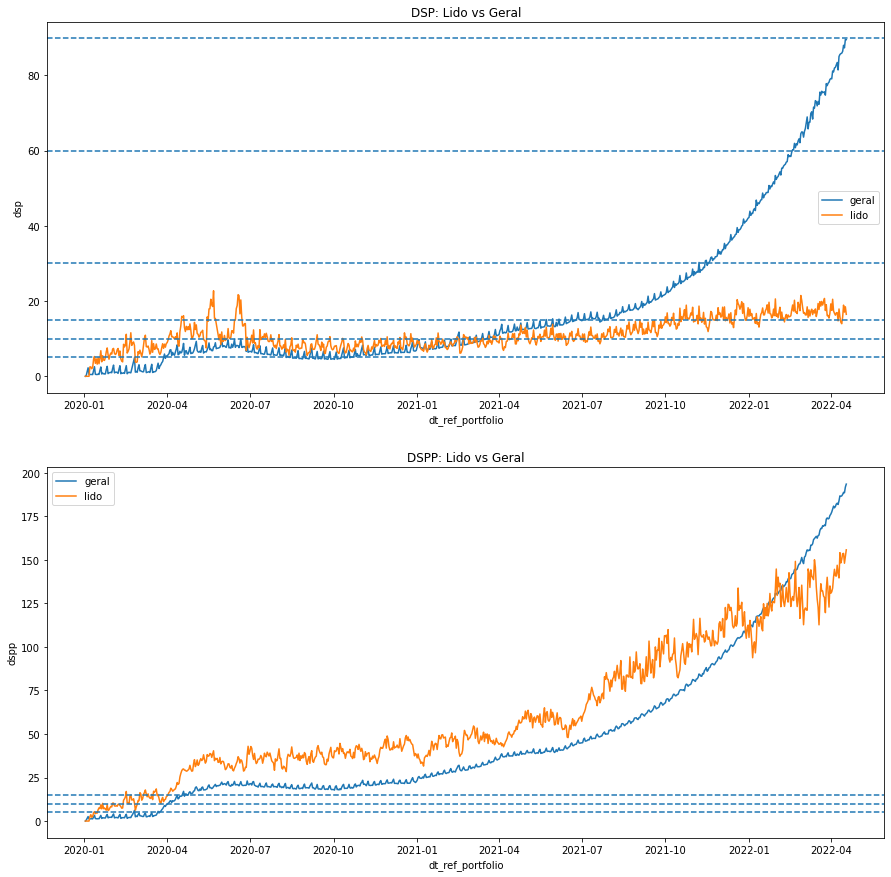

In [592]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
graph = sns.lineplot(data= dsp_geral,x='dt_ref_portfolio', y='dsp' )
graph = sns.lineplot(data= dsp_lido,x='dt_ref_portfolio', y='dsp' )
graph.axhline(5, ls='--')
graph.axhline(10, ls='--')
graph.axhline(15, ls='--')
graph.axhline(30, ls='--')
graph.axhline(60, ls='--')
graph.axhline(90, ls='--')
graph.set_title('DSP: Lido vs Geral')
graph.legend(['geral', 'lido']);

plt.subplot(2,1,2)
graph = sns.lineplot(data= dspp_geral,x='dt_ref_portfolio', y='dspp' )
graph = sns.lineplot(data= dspp_lido,x='dt_ref_portfolio', y='dspp' )
graph.axhline(5, ls='--')
graph.axhline(10, ls='--')
graph.axhline(15, ls='--')
graph.set_title('DSPP: Lido vs Geral')
graph.legend(['geral', 'lido']);

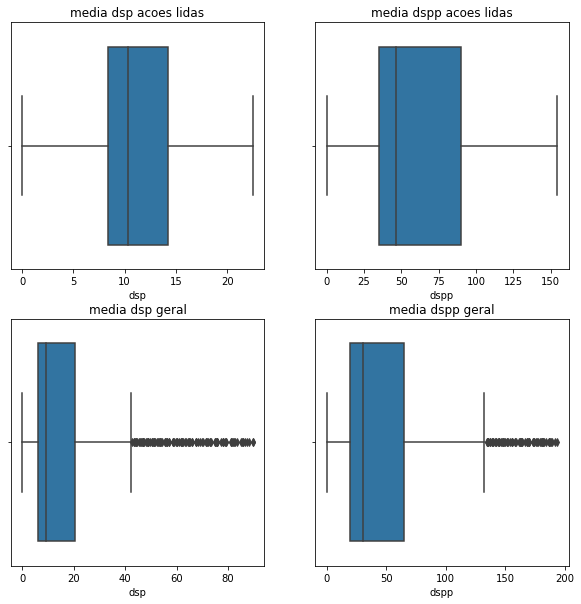

In [19]:
plt.figure(figsize=(10,10))


plt.subplot(2,2,1)
sns.boxplot(aux0['dsp']).set_title('media dsp acoes lidas')

plt.subplot(2,2,2)
sns.boxplot(aux1['dspp']).set_title('media dspp acoes lidas')


plt.subplot(2,2,3)
sns.boxplot(aux3['dsp']).set_title('media dsp geral')


plt.subplot(2,2,4)
sns.boxplot(aux2['dspp']).set_title('media dspp geral');



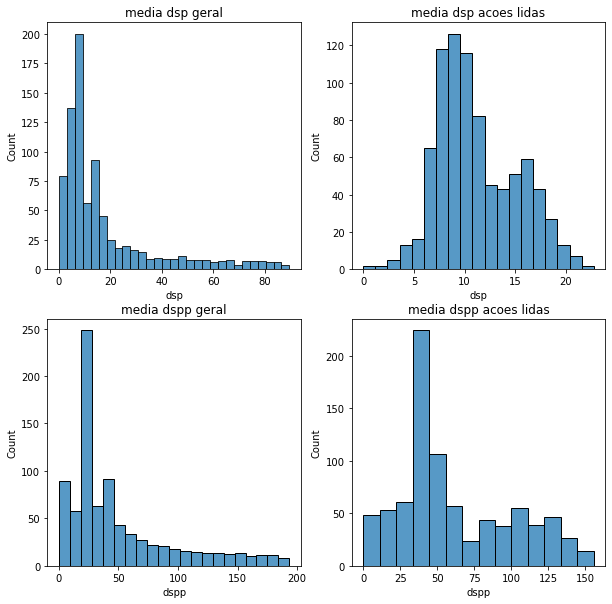

In [520]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.histplot(aux3['dsp']).set_title('media dsp geral')

plt.subplot(2,2,2)
sns.histplot(aux0['dsp']).set_title('media dsp acoes lidas')

plt.subplot(2,2,3)
sns.histplot(aux2['dspp']).set_title('media dspp geral');

plt.subplot(2,2,4)
sns.histplot(aux1['dspp']).set_title('media dspp acoes lidas');

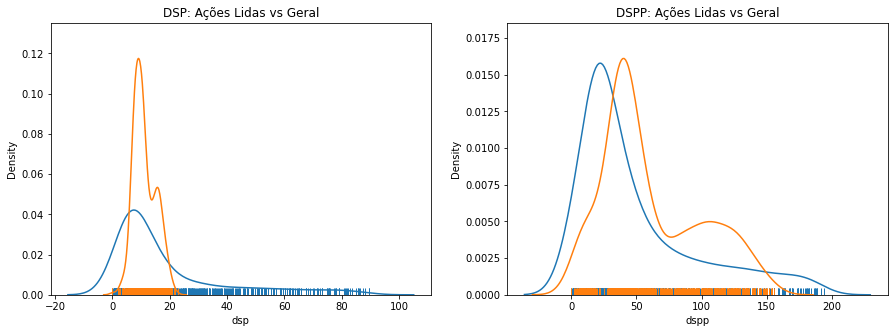

In [576]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(aux3['dsp'], hist=False, rug=True) #geral
sns.distplot(aux0['dsp'], hist=False, rug=True).set_title('DSP: Ações Lidas vs Geral')

plt.subplot(1,2,2)
sns.distplot(aux2['dspp'], hist=False, rug=True) #geral
sns.distplot(aux1['dspp'], hist=False, rug=True).set_title('DSPP: Ações Lidas vs Geral'); 


In [573]:
sns.distplot?

In [538]:
sns.distplot?

### Construindo feature eficiencia

In [513]:
# index_lido = df_lido.loc[df_lido['status'].isin(['LIDO', 'RESPONDIDO']), :].index

# for index, i in enumerate(index_lido):
#     print(f'{index}/{len(index_lido)}')
    
#     if df_lido.loc[i,'status']:

#         if df_lido.loc[i,'dsp']==0: 
#             pass

#         else:
#             for i2 in range(i+1, i+6):
#                 if df_lido.loc[i2, 'dsp']==0:
# #                     eficiencia+=1
#                     df_lido.loc[i,'eficiencia']=1
    
#                     if df_lido.loc[i2, 'dspp']==0:
#                         df_lido.loc[i,'eficiencia']=2
                        
#                 else: 
#                     pass
        


# df_lido['eficiencia'] = df_lido['eficiencia'].fillna(0)

In [21]:
#df_lido to csv
# df_lido.to_csv('df_lido.csv', index=False)

df_lido.head(300)

,contrato_id,dt_ref_portfolio,nr_documento,status_contrato,perc_retencao,vlr_pgto_realizado,vlr_pgto_esperado,vlr_saldo_devedor,vlr_saldo_devedor_esperado,dsp,...,flag_transacao,qtd_transacoes,vlr_tpv,vlp_pago_tpv,data_acao,tipo_acao,acao,status,debito_sem_pagamento,eficiencia
0,000180509391a5ac66ff83cae603ffb8,2020-12-29,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1960.10,4929.02,5,...,0,0.0,0.00,0.000000,2020-12-29,EMAIL,campanhaobservacao,LIDO,1960.10,0.0
1,000180509391a5ac66ff83cae603ffb8,2020-12-29,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1960.10,4929.02,5,...,0,0.0,0.00,0.000000,2020-12-29,HSM,campanhaobservacao,NAO ENTREGUE,1960.10,0.0
2,000180509391a5ac66ff83cae603ffb8,2020-12-30,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1965.75,4915.73,6,...,0,0.0,0.00,0.000000,NaN,NaN,NaN,NaN,1965.75,0.0
3,000180509391a5ac66ff83cae603ffb8,2020-12-31,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1971.39,4902.41,7,...,0,0.0,0.00,0.000000,NaN,NaN,NaN,NaN,1971.39,0.0
4,000180509391a5ac66ff83cae603ffb8,2021-01-01,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1977.07,4889.06,8,...,0,0.0,0.00,0.000000,NaN,NaN,NaN,NaN,1977.07,0.0
5,000180509391a5ac66ff83cae603ffb8,2021-01-02,7996daab1bbe000bb5d1cc1bf317f390,Active,0.06000,0.00,27.45,1982.75,4875.66,9,...,0,0.0,0.00,0.000000,NaN,NaN,NaN,NaN,1982.75,0.0
6,000c35a61297edadc2842f6d5b4028e1,2021-02-13,1191ebfa94d3ca2e8a02f696aafde4a4,Active,0.18000,0.00,106.19,25979.28,26170.22,5,...,1,17.0,531.00,0.955800,2021-02-15,HSM,campanhaobservacao,LIDO,25979.28,1.0
7,000c35a61297edadc2842f6d5b4028e1,2021-02-14,1191ebfa94d3ca2e8a02f696aafde4a4,Active,0.18000,0.00,106.19,26021.48,26106.53,6,...,1,35.0,1859.00,3.346200,NaN,NaN,NaN,NaN,26021.48,0.0
8,000c35a61297edadc2842f6d5b4028e1,2021-02-15,1191ebfa94d3ca2e8a02f696aafde4a4,Active,0.18000,0.00,106.19,26063.75,26042.73,7,...,1,16.0,472.00,0.849600,NaN,NaN,NaN,NaN,26063.75,0.0
9,000c35a61297edadc2842f6d5b4028e1,2021-02-16,1191ebfa94d3ca2e8a02f696aafde4a4,Active,0.18000,0.00,106.19,26106.09,25978.83,8,...,1,9.0,186.00,0.334800,NaN,NaN,NaN,NaN,26106.09,0.0


### Análise das eficiências

In [22]:
#quantas vezes o pagamento principal foi retornado, depois de um comunicado lido/respondido?
print('O pagamento principal  foi retornado, depois de um comunicado lido/respondido {} vezes'.format(len(df_lido[df_lido['eficiencia']==2])))

print('O pagamento  foi retornado, depois de um comunicado lido/respondido {} vezes'.format(len(df_lido[df_lido['eficiencia']==1])))

print('Total de ações: {} '.format(len(df_lido[df_lido['status']=='LIDO'])))

print('Taxa de eficiencia: {:.2f}% \n (eficiencia/total lido)'.format(len(df_lido[df_lido['eficiencia']==1])/len(df_lido[df_lido['status']=='LIDO'])*100))

O pagamento principal  foi retornado, depois de um comunicado lido/respondido 9571 vezes
O pagamento  foi retornado, depois de um comunicado lido/respondido 21609 vezes
Total de ações: 83488 
Taxa de eficiencia: 25.88% 
 (eficiencia/total lido)


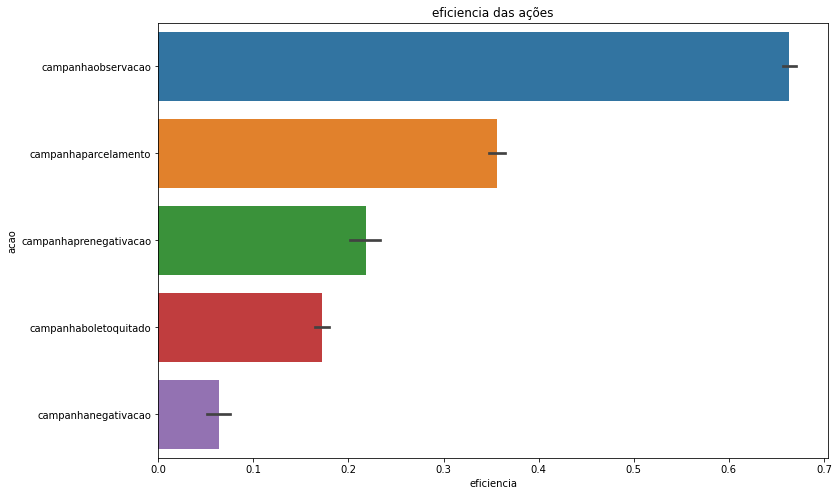

In [23]:
plt.figure(figsize=(12,8))


#eficiencia por acão, filtrando somente linhas que tinham ações lidas ou respondidas
sns.barplot(data=df_lido[df_lido['status'].isin(['LIDO', 'RESPONDIDO'])], y='acao', x='eficiencia', estimator=np.mean).set_title('eficiencia das ações');

Ranking e possível explicação:


1. Campanha de observação: Uma chamada após 5 dias sem pagamento. É a mais eficiente, em grande parte provavelmente por ser a primeira ação tendo poucos dias de inadimplência. Mais da metade volta a pagar depois desse tipo de comunicado.
2. Campanha Parcelamento: Uma chamada após 10 dias sem pagamento. Tem metade da eficiência da primeira, mas não deixa de ser eficiente. 
3. Campanha Pre Negativacao: Uma chamada após um mês sem pagamento. Provavelmente é eficiente por ser uma chamada mais dura e ainda não muito tarde de surtir efeito.
4. Campanha Boleto Quitado: Chamado após 15 dias e também 90. Uma promoção para quitar o boleto, provavelmente com uma promoção.
5. Campanha Negativação: Uma chamada após 60 dias. Negativa efetivamente o nome da pessoa.

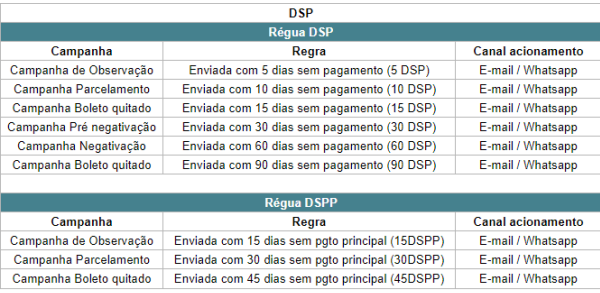

In [514]:
df_lido['eficiencia'].unique()

array([0., 1., 2.])

In [26]:
df_lido[(df_lido['acao']=='campanhaobservacao') ]['eficiencia'].mean()

0.4249593565500128

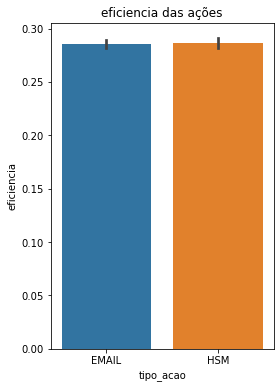

In [27]:
plt.figure(figsize=(4,6))

sns.barplot(data=df_lido, x='tipo_acao', y='eficiencia', estimator=np.mean).set_title('eficiencia das ações');

### Features de contrato

In [28]:
df_contrato.head()

,contrato_id,safra,dt_contrato,dt_desembolso,dt_vencimento,dt_wo,prazo,vlr_desembolsado,vlr_tarifa,juros_mes,juros_diario,status_contrato,dsp,dspp,vlr_pgto_realizado,vlp_pago_tpv,valor_total_pago,debito_sem_pagamento,tempo_esperado,dias_de_contrato
0,356c02706c8e74b15004bb5964ade6bb,2020-06-01,2020-06-24,2020-06-29,2020-12-24,2021-12-24,10.26,22686.57,0.0,0.10788,0.00345,Settled,0.716981,0.716981,24673.98,206.492544,24880.472544,22751.75,178,53
1,1eb0e13f83f336146227ccc9efb08c47,2020-07-01,2020-07-26,2020-07-28,2021-10-26,2022-10-26,25.65,16074.00,0.0,0.04788,0.00157,Settled,0.598101,0.727848,19954.35,144.779233,20099.129233,16113.74,455,316
2,8b03675f597974ca96f06648e96af6d4,2020-08-01,2020-08-13,2020-08-17,2022-02-13,2023-02-13,30.78,17100.00,0.0,0.05388,0.00176,Settled,0.387029,0.414226,22360.45,138.366851,22498.816851,17125.05,545,478
3,4207c25cdd13aba5a05ae348e889d798,2021-03-01,2021-03-01,2021-03-03,2022-06-01,2023-06-01,25.65,14588.01,0.0,0.04788,0.00157,Active,5.289238,29.735426,11338.61,37.907290,11376.517290,14729.21,455,446
4,7dfdca96b6ff0dd844e5e130aee88b30,2020-11-01,2020-10-31,2020-11-04,2022-01-31,2023-01-31,25.65,68400.00,0.0,0.04788,0.00157,Active,31.884404,45.119266,44526.61,256.306812,44782.916812,68569.77,453,545


###  Join clientes e contrato

In [31]:
df_contrato = pd.merge(df_contrato, df_geral_filtered[['contrato_id', 'nr_documento']], on='contrato_id', how='inner')
df_contrato = pd.merge( df_contrato,df_cliente, on='nr_documento', how='inner')

df_contrato = df_contrato.drop_duplicates('contrato_id')

#### Correlação entre features numéricas

In [34]:
num_attributes = df_contrato.select_dtypes(['int64', 'float64'])

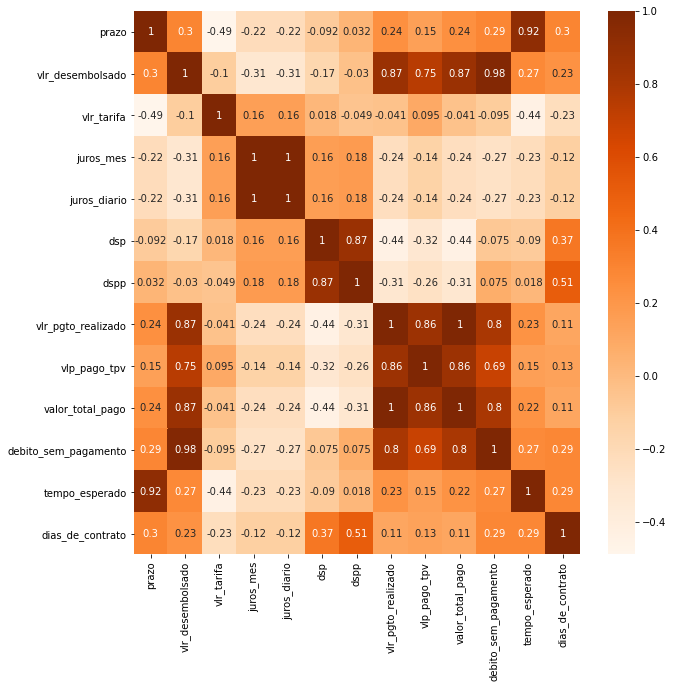

In [151]:
plt.figure(figsize=(10,10))
correlation = num_attributes.corr(method='spearman')
sns.heatmap(correlation, cmap='Oranges', annot=True);

#prazo -> vlr desembolsado
# dsp, dspp -> juros

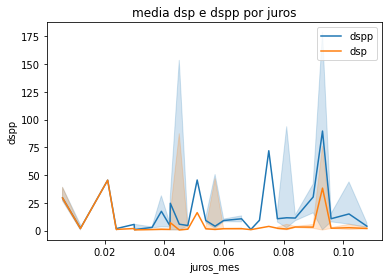

In [36]:


sns.lineplot(data=df_contrato, x='juros_mes', y='dspp', estimator=np.median)
sns.lineplot(data=df_contrato, x='juros_mes', y='dsp', estimator=np.median)
plt.legend(['dspp', 'dsp'])
plt.title('media dsp e dspp por juros');

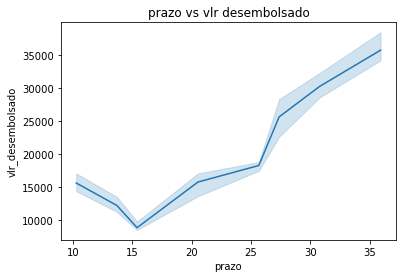

In [37]:
sns.lineplot(data=df_contrato, x='prazo', y='vlr_desembolsado', estimator=np.median)
plt.title('prazo vs vlr desembolsado');

### Inadimplentes

In [38]:
inadimplentes = df_contrato[df_contrato['status_contrato']!='Settled']

#### características

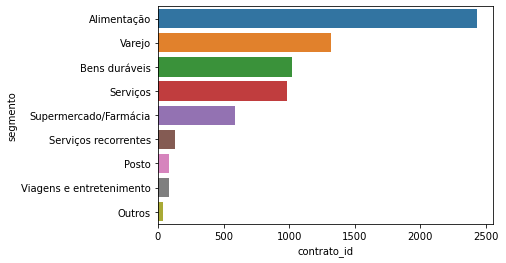

In [72]:

aux = inadimplentes[['segmento', 'contrato_id']].groupby('segmento').count().sort_values('contrato_id', ascending=False).reset_index()
sns.barplot(data=aux,x='contrato_id',y='segmento');


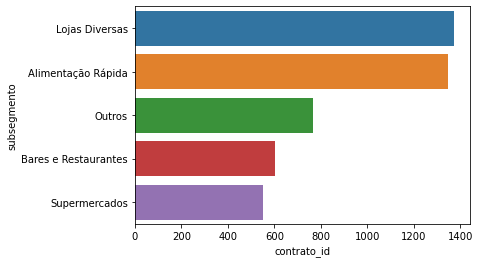

In [75]:
# plot_order = inadimplentes[['estado', 'contrato_id']].groupby('estado').count().sort_values('contrato_id', ascending=False).index.values

aux = inadimplentes[['subsegmento', 'contrato_id']].groupby('subsegmento').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='contrato_id',y='subsegmento');

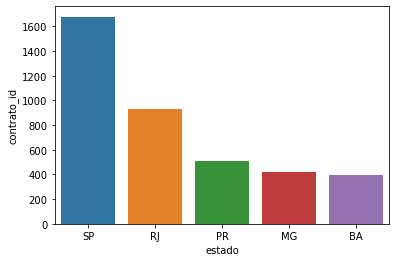

In [74]:
# plot_order = inadimplentes[['estado', 'contrato_id']].groupby('estado').count().sort_values('contrato_id', ascending=False).index.values

aux = inadimplentes[['estado', 'contrato_id']].groupby('estado').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='estado',y='contrato_id');

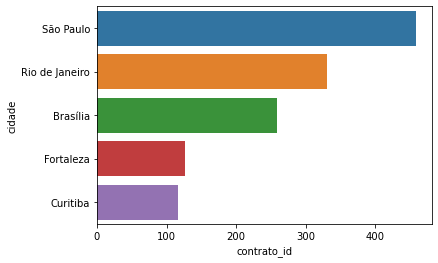

In [73]:
# plot_order = inadimplentes[['estado', 'contrato_id']].groupby('estado').count().sort_values('contrato_id', ascending=False).index.values

aux = inadimplentes[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='contrato_id',y='cidade');

#### características  relativas

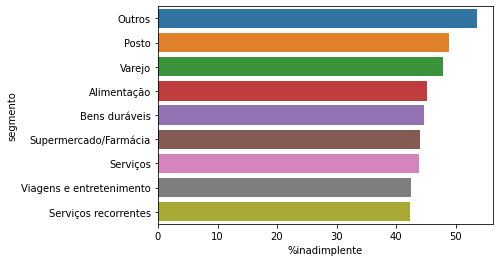

In [159]:
count_bar_plot_p( 'segmento', 'horizontal');

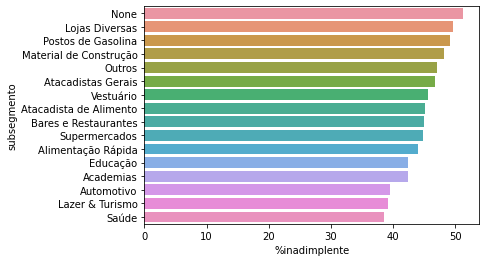

In [162]:
count_bar_plot_p( 'subsegmento', 'horizontal');

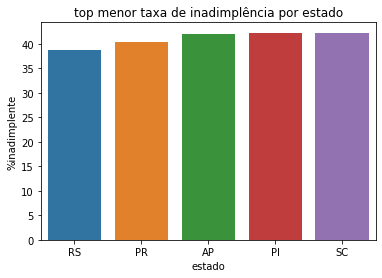

In [171]:
count_bar_plot_p( 'estado', 'vertical', 5, True)
plt.title('top menor taxa de inadimplência por estado');




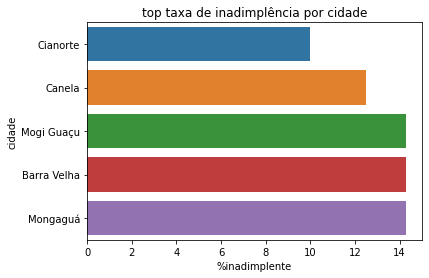

In [174]:
plt.figure(figsize=(6,4))
aux0 = df_contrato[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index()

aux = inadimplentes[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index()

# sns.barplot(data=aux,x='contrato_id',y='cidade');
aux = pd.merge(aux0, aux, on='cidade', how='inner').rename(columns={'contrato_id_x': 'total', 'contrato_id_y':'not_settled' })
aux['%inadimplente'] = 100*aux['not_settled']/aux['total']

aux = aux[aux['total']>100].sort_values('%inadimplente', ascending=False).reset_index().head(5)

sns.barplot(data=aux, x='%inadimplente', y='cidade');
plt.title('top taxa de inadimplência por cidade')



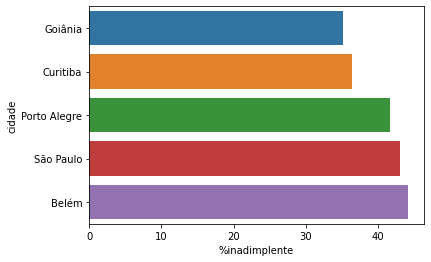

In [143]:

plt.figure(figsize=(6,4))
aux0 = df_contrato[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index()

aux = inadimplentes[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index()

# sns.barplot(data=aux,x='contrato_id',y='cidade');
aux = pd.merge(aux0, aux, on='cidade', how='inner').rename(columns={'contrato_id_x': 'total', 'contrato_id_y':'not_settled' })
aux['%inadimplente'] = 100*aux['not_settled']/aux['total']



aux = aux[aux['total']>100].sort_values('%inadimplente').reset_index().head(5)

sns.barplot(data=aux, x='%inadimplente', y='cidade');
plt.title('top 5 menor taxa de inadimplência por cidade')


Não há muita diferença de inadimplencia por região. 

### Criando df mensagem


In [275]:
# #pegar linha da ação
df_sorted = df_geral_filtered.sort_values(['contrato_id', 'dt_ref_portfolio']).reset_index(drop=True)

#get index of not null messages
index_mensagem = df_sorted.loc[~df_sorted['status'].isna(), :].index

index_mensagem_expanded = index_mensagem
#create index list expanded
for i in range(5):
    index_aux = index_mensagem + 1
    index_mensagem_expanded = index_mensagem_expanded.append(index_aux)


#get df mensagem
df_mensagem = df_sorted.iloc[index_mensagem_expanded, :].sort_values(['contrato_id', 'dt_ref_portfolio']).drop_duplicates().reset_index(drop=True)

#get index das mensagens 
index_mensagem = df_mensagem.loc[df_mensagem['status'].isin(['LIDO', 'RESPONDIDO']), :].index

#create eficiencia
df_lido['eficiencia'] = eficiencia(index_mensagem, df_mensagem, verbose=True)

for index, i in enumerate(index_mensagem):
    print(f'{index}/{len(index_mensagem)}')
    
    if df_mensagem.loc[i,'status']:

        if df_mensagem.loc[i,'dsp']==0: 
            pass

        else:
            for i2 in range(i+1, i+6):
                if df_mensagem.loc[i2, 'dsp']==0:

                    df_mensagem.loc[i,'eficiencia']=1
    
                    if df_mensagem.loc[i2, 'dspp']==0:
                        df_mensagem.loc[i,'eficiencia']=2
                        
                else: 
                    pass
        

#fill null with 0
df_mensagem['eficiencia'] = df_mensagem['eficiencia'].fillna(0)

#create sorted df with less efective 
a = df_mensagem[['contrato_id', 'eficiencia']].groupby('contrato_id').sum().sort_values('eficiencia').reset_index()
a = pd.merge(df_contrato, a, on='contrato_id', how='inner').sort_values(['eficiencia', 'dias_de_contrato'], ascending = [True, False])[['contrato_id', 'dias_de_contrato', 'eficiencia']].reset_index()
df_mensagem_sorted = pd.DataFrame()

#join
for i in range(len(a)):
    print(f'{i}/[{len(a)}')
    aux = df_mensagem[(~df_mensagem['status'].isna())  & (df_mensagem['contrato_id']==a['contrato_id'][i])][['contrato_id','dt_ref_portfolio','dsp', 'dspp', 'acao','status', 'eficiencia']]
    df_mensagem_sorted = pd.concat([df_mensagem_, aux])

df_mensagem_ = df_mensagem_.drop_duplicates().reset_index(drop=True)

#to csv
# df_mensagem_.to_csv('df_mensagem.csv')

### eficiencia vs numero de acoes considerando todas acoes

In [354]:
df_geral_filtered[~df_geral_filtered['acao'].isna()].head()

,contrato_id,dt_ref_portfolio,nr_documento,status_contrato,perc_retencao,vlr_pgto_realizado,vlr_pgto_esperado,vlr_saldo_devedor,vlr_saldo_devedor_esperado,dsp,dspp,flag_transacao,qtd_transacoes,vlr_tpv,vlp_pago_tpv,data_acao,tipo_acao,acao,status,debito_sem_pagamento
50,d01086d5ca765d3bad8a27b2858d5837,2020-10-15,b28af812018cfa98adb66499dc4019ea,Active,0.20184,0.0,122.84,38180.16,21540.52,10,213,1,3.0,1295.000000,2.613828,2020-10-15,HSM,campanhaparcelamento,NAO ENTREGUE,38180.16
51,d01086d5ca765d3bad8a27b2858d5837,2020-10-15,b28af812018cfa98adb66499dc4019ea,Active,0.20184,0.0,122.84,38180.16,21540.52,10,213,1,3.0,1295.000000,2.613828,2020-10-15,EMAIL,campanhaparcelamento,NAO ENTREGUE,38180.16
124,817274b900b4a380a448a1d9d1e36fff,2022-03-01,976220a3fef13b6974b2a4bc0232eb0d,Suspended,1.20000,0.0,36.91,28778.14,0.00,60,546,0,0.0,0.000000,0.000000,2022-03-01,EMAIL,campanhanegativacao,ENTREGUE,28778.14
125,817274b900b4a380a448a1d9d1e36fff,2022-03-01,976220a3fef13b6974b2a4bc0232eb0d,Suspended,1.20000,0.0,36.91,28778.14,0.00,60,546,0,0.0,0.000000,0.000000,2022-03-01,HSM,campanhanegativacao,LIDO,28778.14
190,c1358753bd1a14d8f561ca8be3873d78,2020-05-26,6523965971620af52af326b2000a33e9,Active,0.13296,0.0,38.34,5048.66,4049.72,5,62,1,2.0,413.260242,0.549471,2020-05-26,EMAIL,campanhaobservacao,NAO ENTREGUE,5048.66


In [432]:
df_contrato2 = df_contrato.copy()

#eficiencia
aux = df_mensagem[['contrato_id', 'eficiencia']].groupby('contrato_id').mean().reset_index()
df_contrato2 = pd.merge(df_contrato2, aux, on='contrato_id', how='inner')

#acoes totais
aux = df_geral_filtered[['contrato_id', 'status']].groupby('contrato_id').count().reset_index().rename(columns={'status': 'n_acoes_total'})
df_contrato2 = pd.merge(df_contrato2, aux, on='contrato_id', how='inner')

#acoes entregues
aux = df_geral_filtered [df_geral_filtered['status']!='NAO ENTREGUE'] [['contrato_id', 'status']].groupby('contrato_id').count().reset_index().rename(columns={'status': 'n_acoes_entregues'})
df_contrato2 = pd.merge(df_contrato2, aux, on='contrato_id', how='inner')

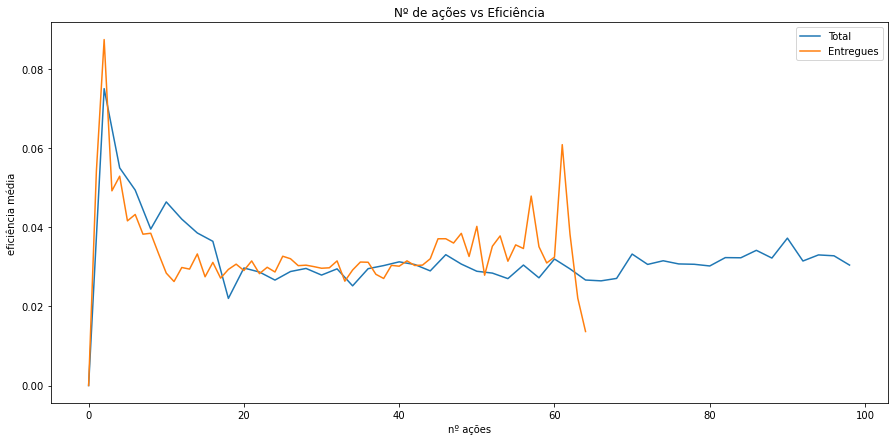

In [497]:
plt.figure(figsize=(15,7))
#
aux = df_contrato2[df_contrato2['n_acoes_total']<100]

graph = sns.lineplot(data=aux, x='n_acoes_total', y='eficiencia', estimator=np.mean, ci=None);
graph = sns.lineplot(data=aux, x='n_acoes_entregues', y='eficiencia',estimator=np.mean, ci=None);
graph.legend( ['Total', 'Entregues']);
plt.xlabel('nº ações')
plt.ylabel('eficiência média')
plt.title('Nº de ações vs Eficiência');

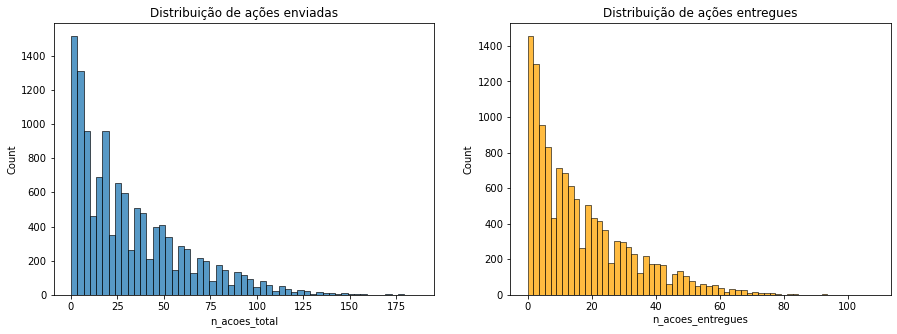

In [477]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(df_contrato2['n_acoes_total']).set_title('Distribuição de ações enviadas')

plt.subplot(1,2,2)
sns.histplot(df_contrato2['n_acoes_entregues'], color='orange').set_title('Distribuição de ações entregues');


Observar o máximo de ações enviadas vs ações entregues.

Enviadas =  + de 175

Entregues = - 100


In [470]:
conversao = sum(df_mensagem['status'].isin(['LIDO', 'RESPONDIDO']))/sum((df_mensagem['status']!='NAO ENTREGUE') & (~df_mensagem['status'].isna()))
print('A conversão é {:.2f}%'.format(conversao*100))

conversao = sum(df_mensagem['status'].isin(['LIDO', 'RESPONDIDO']))/sum( (~df_mensagem['status'].isna()))
print('A conversão é {:.2f}%'.format(conversao*100))

aux = df_mensagem[~df_mensagem['status'].isna()].drop_duplicates()
relacao = aux['status'].value_counts(normalize=True)[0]
print('{:.2f}% dos comunicados enviados não são entregues'.format(100*relacao))

A conversão é 35.09%
A conversão é 18.47%
47.36% dos comunicados enviados não são entregues


0.4735908514349136

### eficiencia vs numero de acoes desconsiderando nao entregues

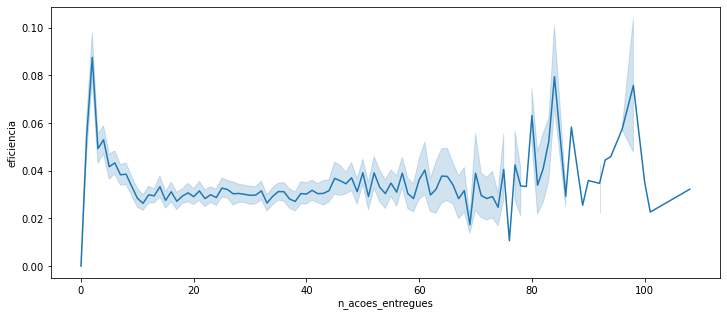

In [436]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_contrato2, x='n_acoes_entregues', y='eficiencia');

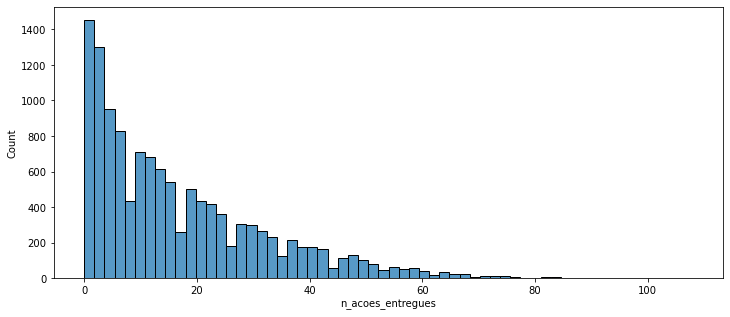

In [437]:
plt.figure(figsize=(12,5))

sns.histplot(df_contrato2['n_acoes_entregues']);